In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import combinations
from collections import defaultdict
import os


In [30]:
weights_path = "/Users/tchanee/Documents/EPFL/MA3/Financial Big Data/project/results/weights/"  #strategy_0d849_weights.jsonl"
numeric_results_path = "/Users/tchanee/Documents/EPFL/MA3/Financial Big Data/project/results/numeric/" #strategy_0d849_results.jsonl"

### Helper Functions

In [66]:
def extract_weights_json(data):
    nd = (
        data.set_index(['start_date', 'test_start_date', 'end_date'])
        .apply(lambda row: pd.Series(zip(row['assets'], row['weights'])), axis=1)
        .stack()
        .reset_index(level=3, drop=True)
        .reset_index()
    )
    nd.columns = ['start_date', 'test_start_date', 'end_date', 'assets_weights']
    nd[['asset', 'weight']] = pd.DataFrame(nd['assets_weights'].tolist(), index=nd.index)
    nd.drop('assets_weights', inplace=True, axis=1)
    nd.columns = ['start_date', 'test_start_date', 'end_date', 'assets', 'weights']
    return nd

def extract_returns_json(data, strategy):
    # Plotting the time series of returns
    plt.figure(figsize=(10, 6))
    data['return'].plot(color='blue')
    plt.title('Time Series of Returns for ' + strategy)
    plt.xlabel('Time windows')
    plt.ylabel('Returns')
    plt.grid(True)
    plt.savefig(f'../plot/{strategy}_ret.png')
    plt.show()
    return data['return'].mean()

def extract_std_json(data, strategy):
    # Plotting the time series of returns
    plt.figure(figsize=(10, 6))
    data['std'].plot(color='red')
    plt.title('Time Series of Std for ' + strategy)
    plt.xlabel('Time windows')
    plt.ylabel('Std')
    plt.grid(True)
    plt.savefig(f'../plot/{strategy}_std.png')
    plt.show()
    return data['std'].mean()

def calculate_l1_distances(data1, data2):
    merged_data = pd.merge(data1, data2, on=['start_date', 'end_date', 'assets'], suffixes=('_1', '_2'))
    merged_data['l1_distance'] = abs(merged_data['weights_1'] - merged_data['weights_2'])
    return merged_data['l1_distance'].tolist()

# Find keys with the most and least elements in common
def analyze_top_bot_stocks(data):
    common_counts = defaultdict(list)
    for key1, key2 in combinations(data.keys(), 2):
        common_elements = set(data[key1]) & set(data[key2])
        common_counts[(key1, key2)].extend(common_elements)

    most_common_keys = max(common_counts, key=lambda k: len(common_counts[k]))
    least_common_keys = min(common_counts, key=lambda k: len(common_counts[k]))

    # Find elements that appear most and least
    all_elements = [element for sublist in data.values() for element in sublist if element is not None]
    element_counts = defaultdict(list)
    for element in set(all_elements):
        count = all_elements.count(element)
        element_counts[count].append(element)

    # Find actual common elements
    most_common_elements = set(data[most_common_keys[0]]) & set(data[most_common_keys[1]])
    least_common_elements = set(data[least_common_keys[0]]) & set(data[least_common_keys[1]])

    # Display the results
    print(f"Keys with the most elements in common: {most_common_keys} (Count: {len(most_common_elements)}) - Elements: {most_common_elements}")
    print(f"Keys with the least elements in common: {least_common_keys} (Count: {len(least_common_elements)}) - Elements: {least_common_elements}")
    print(f"Elements that appear most: {most_common_elements} (Count: {max(element_counts)})")
    print(f"Elements that appear least: {least_common_elements} (Count: {min(element_counts)})")


## Calculating distance between portfolios found using different strategies

In [32]:
# loop through each strategy
# compare the two in each period in l1 distance, then average out at the end

json_files = [f for f in os.listdir(weights_path) if f.endswith('.jsonl')]

# Create a dictionary to store L1 distances for each combination
l1_distances_dict = {}

for i, file1 in enumerate(json_files):
    for j, file2 in enumerate(json_files):
        if i < j:
            file1_path = os.path.join(weights_path, file1)
            file2_path = os.path.join(weights_path, file2)

            data1 = extract_weights_json(pd.read_json(file1_path, lines=True))
            data2 = extract_weights_json(pd.read_json(file2_path, lines=True))

            l1_distances_dict[file1 + "_" + file2] = sum(calculate_l1_distances(data1, data2))
            # l1_distances_dict[file2_path + file1_path] = l1_distances_dict[file1_path + file2_path]
            
l1_distances_dict


{'strategy_39767_weights.jsonl_strategy_a5731_weights.jsonl': 110.41952852387293,
 'strategy_39767_weights.jsonl_strategy_af580_weights.jsonl': 238.52168348594046,
 'strategy_39767_weights.jsonl_strategy_634b5_weights.jsonl': 156.4144451506464,
 'strategy_39767_weights.jsonl_strategy_359d6_weights.jsonl': 27.769538909809107,
 'strategy_39767_weights.jsonl_strategy_4487a_weights.jsonl': 28.21286746530516,
 'strategy_a5731_weights.jsonl_strategy_af580_weights.jsonl': 184.28350696081938,
 'strategy_a5731_weights.jsonl_strategy_634b5_weights.jsonl': 192.71367670633728,
 'strategy_a5731_weights.jsonl_strategy_359d6_weights.jsonl': 18.62542929357091,
 'strategy_a5731_weights.jsonl_strategy_4487a_weights.jsonl': 69.92673475356717,
 'strategy_af580_weights.jsonl_strategy_634b5_weights.jsonl': 55.73687568304154,
 'strategy_af580_weights.jsonl_strategy_359d6_weights.jsonl': 168.19939157539187,
 'strategy_af580_weights.jsonl_strategy_4487a_weights.jsonl': 364.28953758090375,
 'strategy_634b5_weig

In [33]:
# Create a list of strategies
strategies = list(set(strategy.split('_')[1] for strategy in l1_distances_dict.keys()) | set(strategy.split('_')[-2] for strategy in l1_distances_dict.keys()))
print(strategies)

# Initialize dictionaries to store results
closest_strategies = {}
furthest_strategies = {}
average_differences = {}

# Calculate statistics
for strategy in strategies:
    strategy_differences = {k: v for k, v in l1_distances_dict.items() if strategy in k}
    closest_strategy = min(strategy_differences, key=strategy_differences.get)
    furthest_strategy = max(strategy_differences, key=strategy_differences.get)
    average_difference = np.mean(list(strategy_differences.values()))

    closest_strategies[strategy] = {'strategy': closest_strategy, 'difference': strategy_differences[closest_strategy]}
    furthest_strategies[strategy] = {'strategy': furthest_strategy, 'difference': strategy_differences[furthest_strategy]}
    average_differences[strategy] = average_difference

# Display results
print("Closest Strategies:")
for strategy, info in closest_strategies.items():
    print(f"{strategy}: {info['strategy']} (Difference: {info['difference']:.2f})")

print("\nFurthest Strategies:")
for strategy, info in furthest_strategies.items():
    print(f"{strategy}: {info['strategy']} (Difference: {info['difference']:.2f})")

print("\nAverage Differences:")
for strategy, avg_diff in average_differences.items():
    print(f"{strategy}: {avg_diff:.2f}")

['634b5', '359d6', '39767', 'a5731', '4487a', 'af580']
Closest Strategies:
634b5: strategy_634b5_weights.jsonl_strategy_359d6_weights.jsonl (Difference: 20.90)
359d6: strategy_a5731_weights.jsonl_strategy_359d6_weights.jsonl (Difference: 18.63)
39767: strategy_39767_weights.jsonl_strategy_359d6_weights.jsonl (Difference: 27.77)
a5731: strategy_a5731_weights.jsonl_strategy_359d6_weights.jsonl (Difference: 18.63)
4487a: strategy_39767_weights.jsonl_strategy_4487a_weights.jsonl (Difference: 28.21)
af580: strategy_af580_weights.jsonl_strategy_634b5_weights.jsonl (Difference: 55.74)

Furthest Strategies:
634b5: strategy_a5731_weights.jsonl_strategy_634b5_weights.jsonl (Difference: 192.71)
359d6: strategy_af580_weights.jsonl_strategy_359d6_weights.jsonl (Difference: 168.20)
39767: strategy_39767_weights.jsonl_strategy_af580_weights.jsonl (Difference: 238.52)
a5731: strategy_a5731_weights.jsonl_strategy_634b5_weights.jsonl (Difference: 192.71)
4487a: strategy_af580_weights.jsonl_strategy_4487

In [40]:
# Strategy of interest: most basic one, no cleaning and natural estimation of covariance
interest_strategy = '4487a'

# Initialize dictionary to store results
distances_from_interest_strategy = {}

# Calculate distances for the '359d6' strategy
for other_strategy in strategies:
    if other_strategy != interest_strategy:
        strategy_key = f'strategy_{interest_strategy}_weights.jsonl_strategy_{other_strategy}_weights.jsonl'
        if strategy_key in l1_distances_dict:
            distance = l1_distances_dict[strategy_key]
            distances_from_interest_strategy[other_strategy] = distance
        else:
            strategy_key = f'strategy_{other_strategy}_weights.jsonl_strategy_{interest_strategy}_weights.jsonl'
            if strategy_key in l1_distances_dict:
                distance = l1_distances_dict[strategy_key]
                distances_from_interest_strategy[other_strategy] = distance

# Display distances for the '359d6' strategy
print(f"Distances from '4487a' strategy:")
for other_strategy, distance in distances_from_interest_strategy.items():
    print(f"{other_strategy}: {distance:.2f}")

Distances from '4487a' strategy:
634b5: 154.61
359d6: 98.25
39767: 28.21
a5731: 69.93
af580: 364.29


## Returns of each strategy

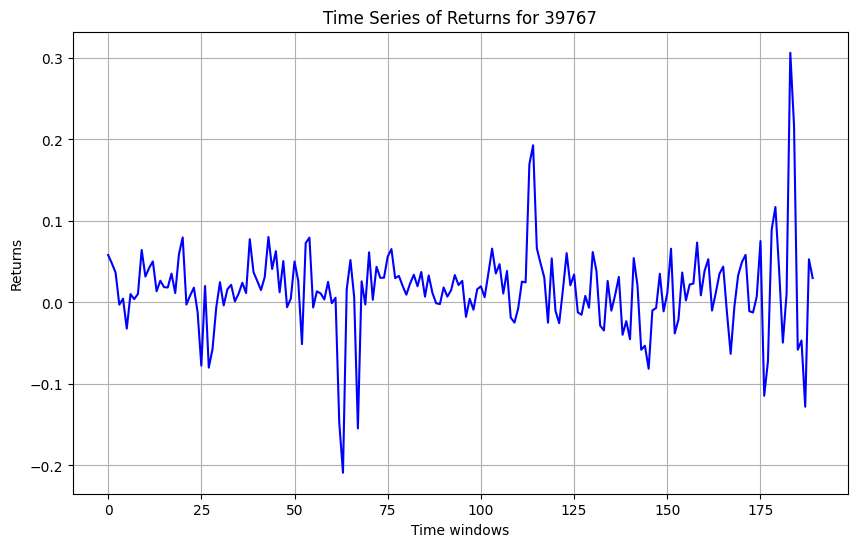

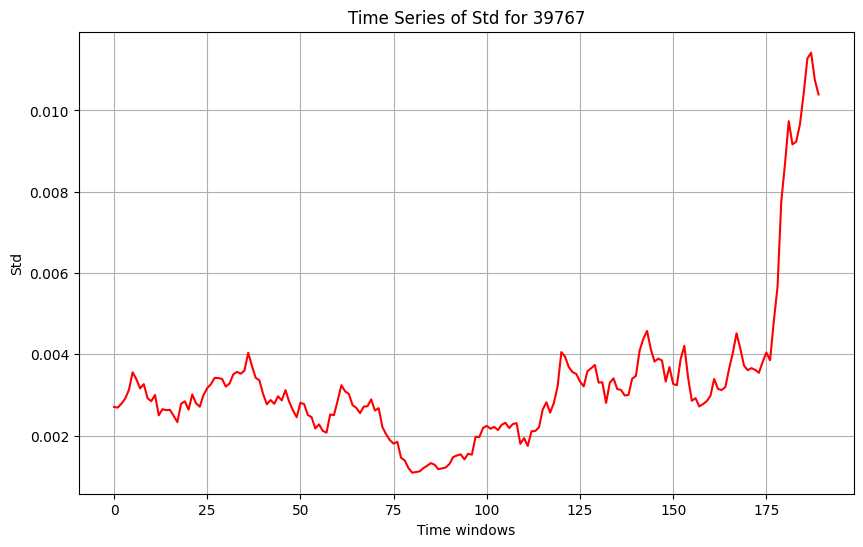

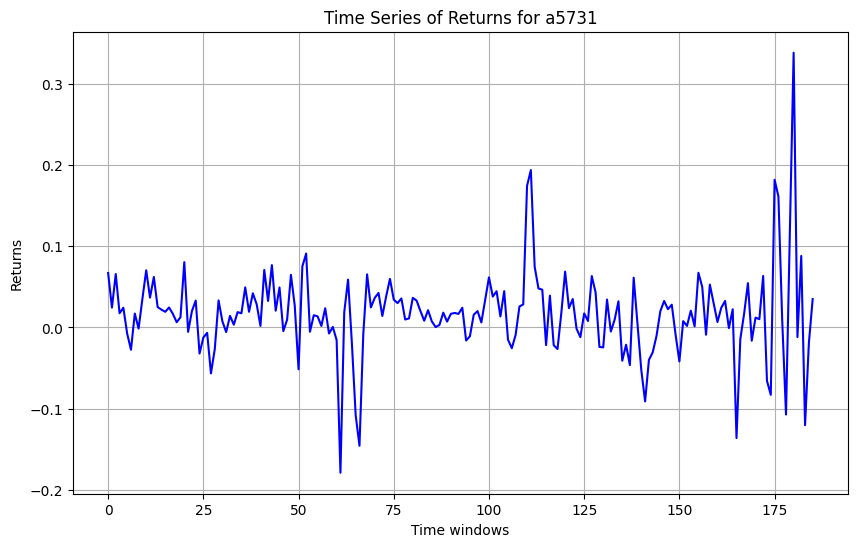

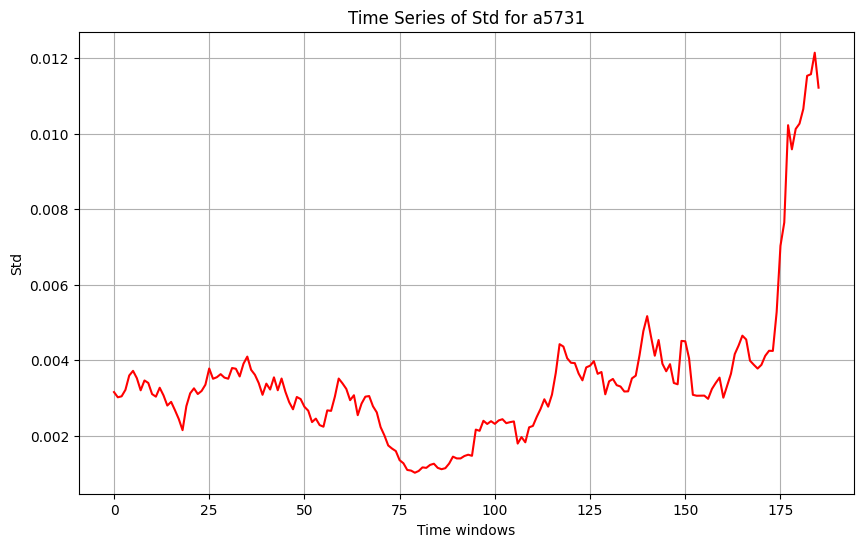

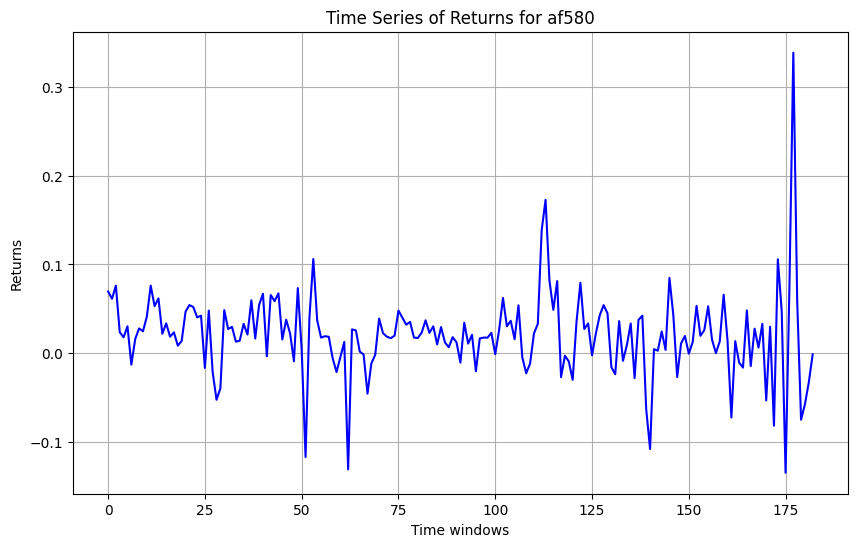

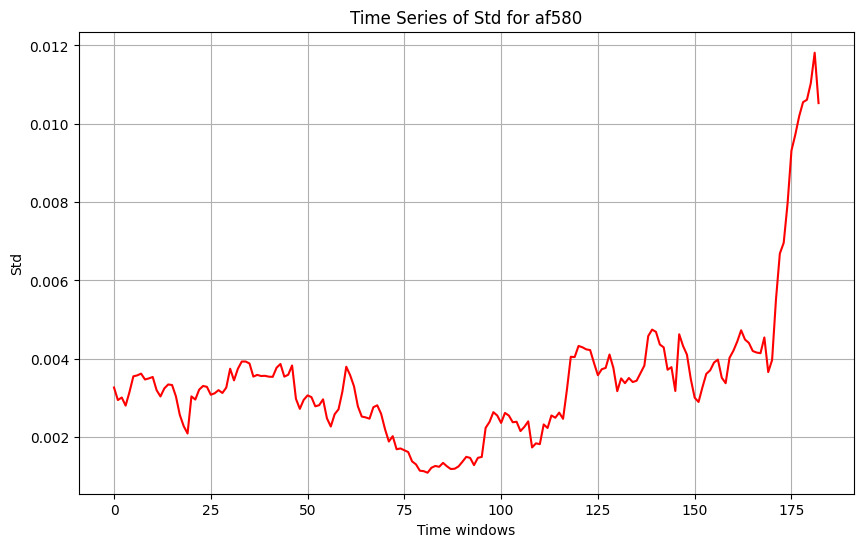

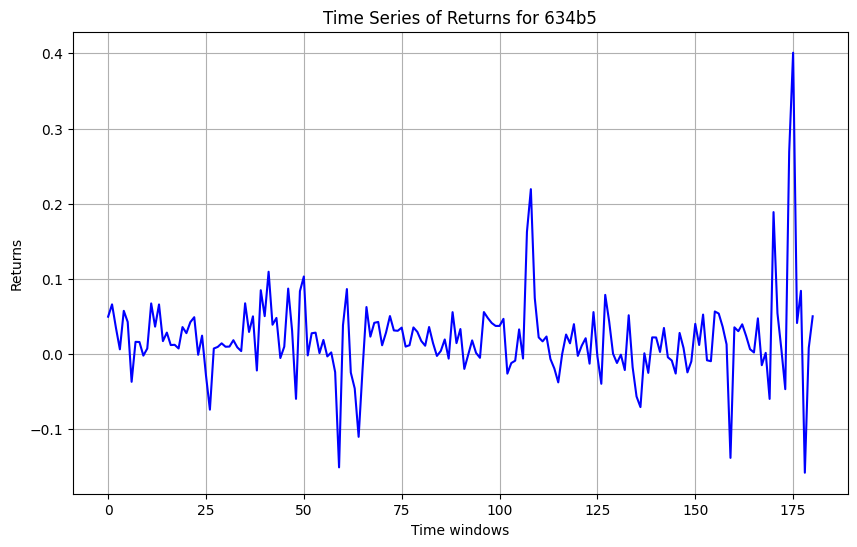

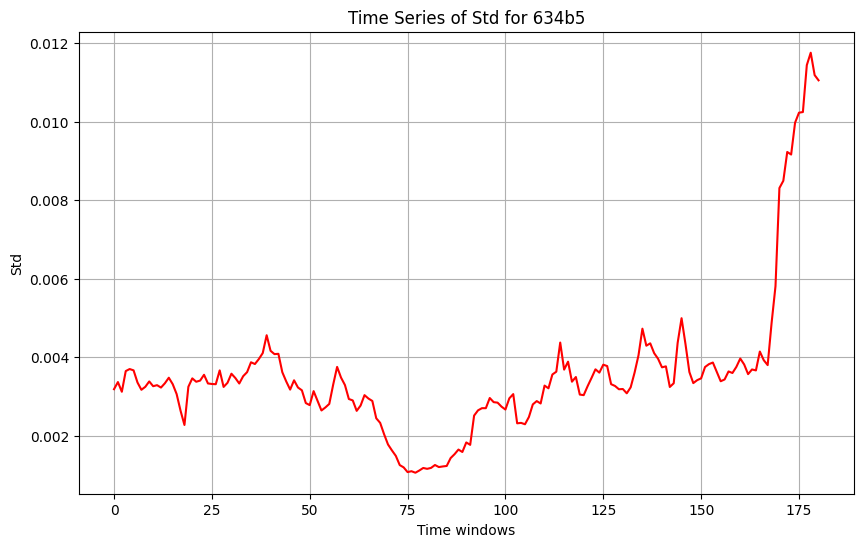

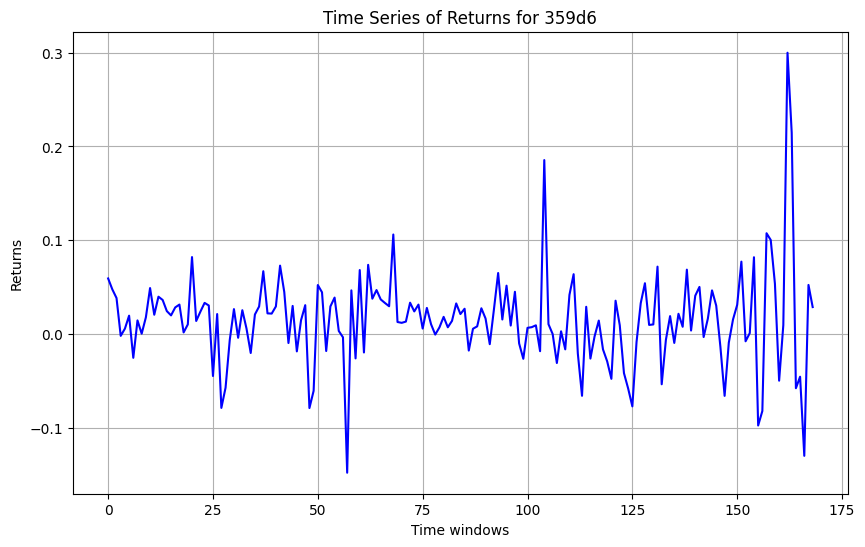

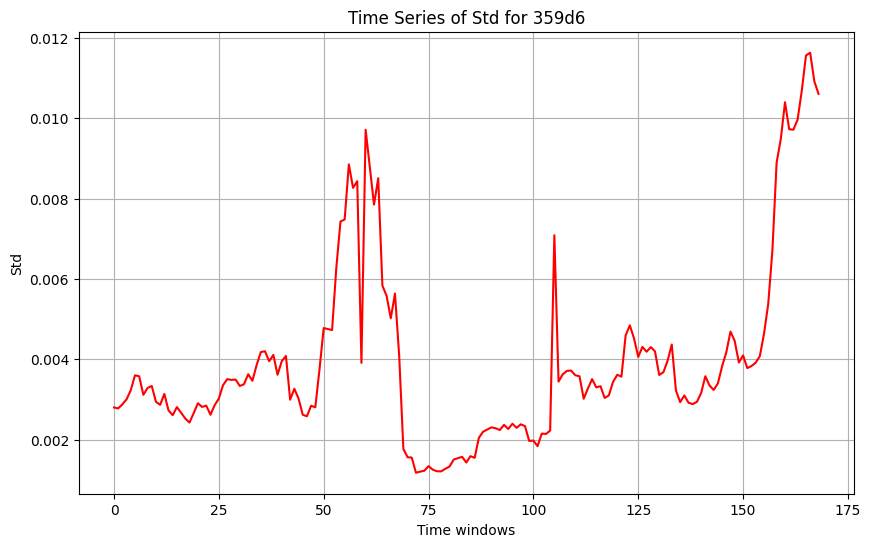

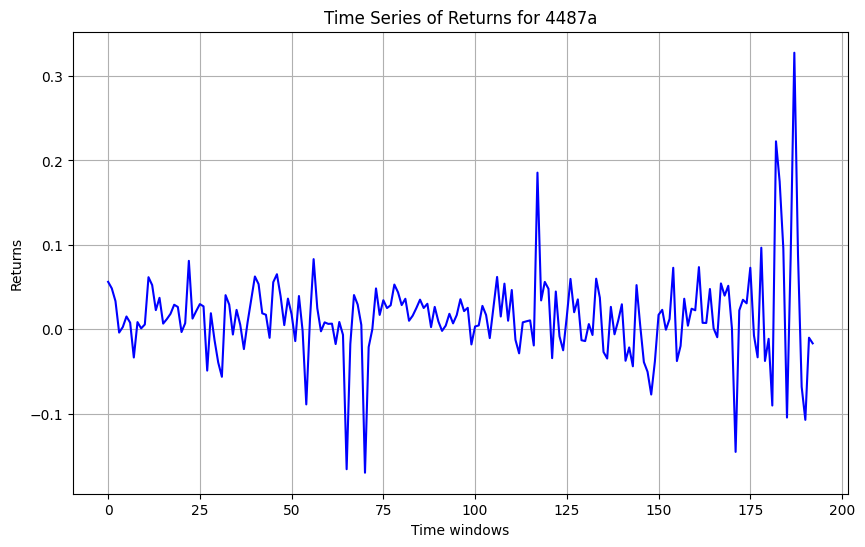

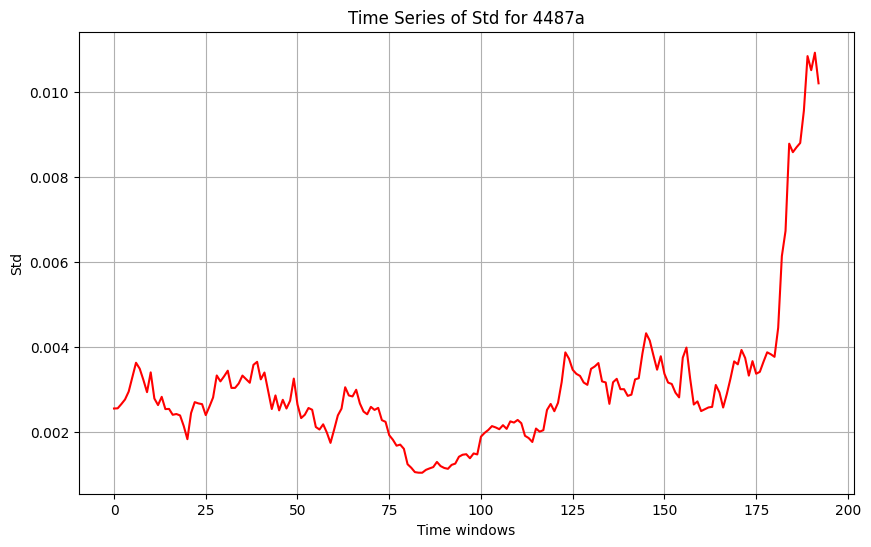

Return & std & simple sharpe ratio (no risk-free asset) of each strategy


{'39767': '0.016||0.003256||4.893',
 'a5731': '0.017||0.003454||4.890',
 'af580': '0.020||0.003449||5.931',
 '634b5': '0.021||0.003555||5.911',
 '359d6': '0.015||0.003956||3.774',
 '4487a': '0.014||0.003040||4.755'}

In [67]:
# Lets now look at the returns
results_json_files = [f for f in os.listdir(numeric_results_path) if f.endswith('.jsonl')]
strategy_return_dict = {}
strategy_std_dict = {}

for _, file in enumerate(results_json_files):
        file_path = os.path.join(numeric_results_path, file)
        returns = extract_returns_json(pd.read_json(file_path, lines=True), file.split('_')[1])
        stds = extract_std_json(pd.read_json(file_path, lines=True), file.split('_')[1])
        strategy_return_dict[file.split('_')[1]] = f"{returns:.3f}||{stds:3f}||{returns/stds:.3f}"
        strategy_std_dict[file.split('_')[1]] = f"{stds:.4f}"

print("Return & std & simple sharpe ratio (no risk-free asset) of each strategy")
strategy_return_dict

## Find top and bottom 5 stocks (by weight) and the ones that are most in common for the different strategies

In [36]:
# Let's look at the top 5 stocks that are the most under/over-valued over time with the different techniques

json_files = [f for f in os.listdir(weights_path) if f.endswith('.jsonl')]

bot_5_weights_dict = {}
top_5_weights_dict = {}

for i, file in enumerate(json_files):
    # Dicts to store top 5 positive and top 5 negative weight stocks. used to count occurences
    highest_weight_dict = {}
    lowest_weight_dict  = {}


    file_path = os.path.join(weights_path, file)
    data = pd.read_json(file_path, lines=True, orient='columns')

    assets = data["assets"]
    weights = data["weights"]
    assets_weights = data[["assets", "weights"]]

    # Sort each list and track the original indices
    sorted_data = []
    for i, row in assets_weights.iterrows():
        #storing the original index only, we dont actually care about the weight here
        sorted_weights = [idx for idx, w in sorted(enumerate(row['weights']), key=lambda x: x[1])]
        sorted_data.append({'weights': sorted_weights})

    # Create a new Pandas Series with sorted lists and original indices
    result = pd.Series([entry['weights'] for entry in sorted_data], index=weights.index)
    result = result.apply(lambda indexes: [row[i] if i < len(row) else None for row, i in zip(assets, indexes)])
    
    for row in result:
        bottom_5 = row[:5] 
        top_5 = row[-5:] 
        
        for elem in bottom_5:
            if not elem in lowest_weight_dict: lowest_weight_dict[elem] = 1
            else: lowest_weight_dict[elem] += 1

        for elem in top_5:
            if not elem in highest_weight_dict: highest_weight_dict[elem] = 1
            else: highest_weight_dict[elem] += 1

    lowest_weight_dict = sorted(lowest_weight_dict, key=lowest_weight_dict.get, reverse=True)[:5]
    highest_weight_dict = sorted(highest_weight_dict, key=highest_weight_dict.get, reverse=False)[:5]

    top_5_weights_dict[file.split('_')[1]] = highest_weight_dict
    bot_5_weights_dict[file.split('_')[1]] = lowest_weight_dict
    
print(top_5_weights_dict)
print(bot_5_weights_dict)

{'39767': ['ret_FDX', 'ret_AXP', 'ret_DOW', 'ret_HD', 'ret_HON'], 'a5731': ['ret_TXN', 'ret_ALL', 'ret_APA', 'ret_NOV', 'ret_WY'], 'af580': ['ret_GS', 'ret_WY', 'ret_DD', 'ret_DOW', 'ret_VZ'], '634b5': ['ret_TXN', 'ret_DD', 'ret_MET', None, 'ret_HON'], '359d6': ['ret_WMB', 'ret_DOW', 'ret_HD', 'ret_PFE', 'ret_HON'], '4487a': ['ret_DOW', 'ret_DD', 'ret_HON', 'ret_F', 'ret_MS']}
{'39767': ['ret_COP', 'ret_UTX', 'ret_EMR', 'ret_GE', 'ret_PFE'], 'a5731': ['ret_COP', 'ret_UTX', 'ret_EMR', 'ret_GE', 'ret_EMC'], 'af580': ['ret_COP', 'ret_PFE', 'ret_UTX', 'ret_GE', 'ret_TGT'], '634b5': ['ret_COP', 'ret_UTX', 'ret_GE', 'ret_PFE', 'ret_WMT'], '359d6': ['ret_COP', 'ret_AA', 'ret_GE', 'ret_UTX', 'ret_TGT'], '4487a': ['ret_COP', 'ret_EMR', 'ret_UTX', 'ret_GE', 'ret_T']}


In [37]:
analyze_top_bot_stocks(top_5_weights_dict)

Keys with the most elements in common: ('39767', '359d6') (Count: 3) - Elements: {'ret_DOW', 'ret_HD', 'ret_HON'}
Keys with the least elements in common: ('39767', 'a5731') (Count: 0) - Elements: set()
Elements that appear most: {'ret_DOW', 'ret_HD', 'ret_HON'} (Count: 4)
Elements that appear least: set() (Count: 1)


In [38]:
analyze_top_bot_stocks(bot_5_weights_dict)

Keys with the most elements in common: ('39767', 'a5731') (Count: 4) - Elements: {'ret_COP', 'ret_EMR', 'ret_GE', 'ret_UTX'}
Keys with the least elements in common: ('39767', '359d6') (Count: 3) - Elements: {'ret_COP', 'ret_GE', 'ret_UTX'}
Elements that appear most: {'ret_COP', 'ret_EMR', 'ret_GE', 'ret_UTX'} (Count: 6)
Elements that appear least: {'ret_COP', 'ret_GE', 'ret_UTX'} (Count: 1)
